In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.8 MB/s eta 0:00:00


In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 19.0 MB/s eta 0:00:00


In [3]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=259f1a758b548ab1b5c3731cdc17610c615902dfaad209b3d2657424a9d128ee
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [4]:
import json
import re
import random
import numpy as np
import pandas as pd
import torch
import emoji
import math

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

import torch.optim as optim
from torch.optim import AdamW, Adam, SGD

import transformers
from transformers import AutoModel, BertTokenizerFast, RobertaTokenizer, RobertaModel, T5EncoderModel,T5Tokenizer
# from sentence_transformers import SentenceTransformer 
from transformers import get_linear_schedule_with_warmup

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import contractions

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def merge_text_truth(input_file, output_file):
    examples = []
    output_data = []
    with open(output_file, 'r', encoding='utf-8') as f:
      for line in f:
          obj = json.loads(line)
          output_data.append(obj)
    data = {item['twitter user id']: {"twitter user id":item['twitter user id'],
                                      "class":item['class'].strip()} for item in output_data}
    
    with open(input_file, 'r') as f:
        for line in f:
          obj = json.loads(line)
          data[obj['twitter user id']]['texts'] = obj['texts']
    return list(data.values())
data = merge_text_truth('./train_text.json','train_truth.json')

In [7]:
def split_and_save(data, test_size=0.1):
  train_data, val_data = train_test_split(data, 
                                          random_state=40, 
                                          test_size=test_size, 
                                          shuffle=True)
  with open('train.json', 'w', encoding='utf-8') as f:
    for obj in train_data:
      f.write(json.dumps(obj))
      f.write('\n')
  f.close()

  with open('val.json', 'w', encoding='utf-8') as f:
    for obj in val_data:
      f.write(json.dumps(obj))
      f.write('\n')
  f.close()
  return train_data, val_data
train_data, val_data = split_and_save(data, 0.1)

In [8]:
def remove_emoji(text):
    return re.sub('\s+', ' ', re.sub(':\S+?:', ' ', emoji.demojize(text)))

def remove_long_words(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) <= 40]
    return " ".join(filtered_words)

def preprocess_text(text):
  # reemplazar las urls
  text = re.sub(r'http\S+', 'http', text)
  # drop letters that start at @&
  text = re.sub(r'[&][^\s]+', '', text)
  text = re.sub(r'[@][^\s]+', '@user', text)
  #drop all new lines
  text = re.sub(r"[\r\n]+", " ", text)
  #drop emojis
  text = remove_emoji(text)
  # Convertir todo el texto a minúsculas
  text = text.lower()
  #Sustituir los Retweets
  text = re.sub(r'\b(RT|rt)\b\s+', ' ', text)
  # reemplazar múltiples espacios con un solo espacio
  text = re.sub(r'\s+', ' ', text)
  #eliminar secuencia de palabras repetidas
  text = re.sub(r'([@]*[a-zA-Z]{1,}\s+)\1+', r'\1', text)
  text = remove_long_words(text)
  # reemplazar múltiples espacios con un solo espacio
  text = re.sub(r'\s+', ' ', text)
  #remove white space at begin and end of line
  text = text.strip()

  return text

In [9]:
class InputExample(object):
    def __init__(self, twitter_id, text, label):
      self.twitter_id = twitter_id
      self.text = text
      self.label = label

def dataToInputExample(dataset, max_length=80):
    examples = []
    labels = []
    for data in dataset:
      text = [text['text'] for text in data['texts']]
      text = ' '.join(text)
      print(text)
      text = preprocess_text(text)
      if len(text)<1 or text is None:
        continue
      print(text)
      text_split = text.split()
      text_length = len(text_split)
      for i in range(math.ceil(text_length/max_length)):
        labels.append(data['class'])
        if (i+1)*max_length>= text_length:
          examples.append(InputExample(twitter_id=data['twitter user id'], text=' '.join(text_split[-max_length:]), label=data['class']))
        else:
          examples.append(InputExample(twitter_id=data['twitter user id'], text=' '.join(text_split[i*max_length:(i+1)*max_length]), label=data['class']))
    return examples, labels
_ = dataToInputExample(val_data)

More unique #art #meme #NFTs for our future Bored Doge #NFT collection with 2D/3D #Metaverse #GameFi Utility on #NEO #blockchain .  $NEO will be the first blockchain with a #doge #shiba multiplayer Metaverse #PlayToEarn  Game!  #MetaverseNFT https://t.co/pd3ngSYK6h
more unique #art #meme #nfts for our future bored doge #nft collection with 2d/3d #metaverse #gamefi utility on #neo #blockchain . $neo will be the first blockchain with a #doge #shiba multiplayer metaverse #playtoearn game! #metaversenft http
What a year full of challenges, achievements, and growth. Discover the highlights of 2021 in our comprehensive – but never exhaustive – IOG review of the year 🌟   #Cardano $ADA  https://t.co/NKp0RMZ7E1
what a year full of challenges, achievements, and growth. discover the highlights of 2021 in our comprehensive – but never exhaustive – iog review of the year #cardano $ada http
Looks rare Now i hv 2 Ultra rare 👀 https://t.co/efAPDdXhTa Buy now before sold out #GCG #NFT #NFTCommunity #NF

In [10]:
class CryptocurrencyDataset(Dataset):
    def __init__(self, data, tokenizer, seq_length=16, n_ways=5, k_shots=1, k_queries=5):
        self.n_ways = n_ways
        self.k_shots = k_shots
        self.k_queries = k_queries
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        proto_examples, proto_labels = data
        self.proto_features = [self.text_to_features(example.text) for example in proto_examples]
        self.proto_labels = np.array(proto_labels)
        self.proto_classes = np.array(list(set(self.proto_labels)))
        self.proto_classes_to_id = {v:k for k, v in enumerate(self.proto_classes)}
        self.id_to_proto_classes = {v:k for k, v in self.proto_classes_to_id.items()}
        self.nb_proto_classes = len(self.proto_classes)

    def __len__(self):
        return len(self.proto_labels)*self.n_ways*self.k_shots*self.k_queries

    def __getitem__(self, item_poss):
        support, support_mask, support_label = [], [], []
        query, query_mask, query_label = [], [], []
        target_classes = np.random.choice(self.proto_classes, self.n_ways, replace=False)
        for class_idx, class_name in enumerate(target_classes):
            support.append([])
            support_mask.append([])
            query.append([])
            query_mask.append([])
            label_index = np.argwhere(self.proto_labels==class_name).reshape(-1,)
            samples = np.random.choice(label_index, self.k_shots + self.k_queries, replace=False)
            for idx, sample in enumerate(samples):
              if idx < self.k_shots:
                support[class_idx].append(self.proto_features[sample].input_ids)
                support_mask[class_idx].append(self.proto_features[sample].attention_mask)
                support_label.append(self.proto_classes_to_id[class_name])
              else:
                query[class_idx].append(self.proto_features[sample].input_ids)
                query_mask[class_idx].append(self.proto_features[sample].attention_mask)
                query_label.append(self.proto_classes_to_id[class_name])
            
        return (torch.tensor(support, dtype=torch.long),
                torch.tensor(support_mask, dtype=torch.long),
                torch.tensor(query, dtype=torch.long),
                torch.tensor(query_mask, dtype=torch.long),
                torch.tensor(support_label, dtype=torch.long),
                torch.tensor(query_label, dtype=torch.long))
        
    def text_to_features(self, inputs):
      if isinstance(inputs, str):
        encode = self.tokenizer.encode_plus(
          inputs,
          max_length = self.seq_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_token_type_ids=False,
          add_special_tokens = True,
          # return_tensors = 'pt',
          )
      else:
        encode = self.tokenizer.batch_encode_plus(
          inputs,
          max_length = self.seq_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_token_type_ids=False,
          add_special_tokens = True,
          return_tensors = 'pt',
          )
      # return encode['input_ids'], encode['attention_mask']
      return encode

In [11]:
class CryptocurrencyDatasetEval(Dataset):
    def __init__(self, train_data, val_data, tokenizer, seq_length=16, n_ways=5, k_shots=1):
        self.n_ways = n_ways
        self.k_shots = k_shots
        # self.k_queries = k_queries
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        proto_examples, proto_labels = train_data
        self.proto_features = [self.text_to_features(example.text) for example in proto_examples]
        self.proto_labels = np.array(proto_labels)
        self.proto_classes = np.array(list(set(self.proto_labels)))
        self.proto_classes_to_id = {v:k for k, v in enumerate(self.proto_classes)}
        self.id_to_proto_classes = {v:k for k, v in self.proto_classes_to_id.items()}
        self.nb_proto_classes = len(self.proto_classes)

        examples, labels = val_data
        self.features = [self.text_to_features(example.text) for example in examples]
        self.labels = np.array(labels)
        self.classes = np.array(list(set(self.labels)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item_poss):
        support, support_mask, support_label = [], [], []
        query, query_mask, query_label = [], [], []
        target_classes = np.random.choice(self.proto_classes, self.n_ways, replace=False)
        for class_idx, class_name in enumerate(target_classes):
            support.append([])
            support_mask.append([])
            label_index = np.argwhere(self.proto_labels==class_name).reshape(-1,)
            samples = np.random.choice(label_index, self.k_shots, replace=False)
            for idx, sample in enumerate(samples):
              support[class_idx].append(self.proto_features[sample].input_ids)
              support_mask[class_idx].append(self.proto_features[sample].attention_mask)
              support_label.append(self.proto_classes_to_id[class_name])

        query.append([])
        query_mask.append([])
        query[0].append(self.features[item_poss].input_ids)
        query_mask[0].append(self.features[item_poss].attention_mask)
        query_label.append(self.proto_classes_to_id[self.labels[item_poss]])
            
        return (torch.tensor(support, dtype=torch.long),
                torch.tensor(support_mask, dtype=torch.long),
                torch.tensor(query, dtype=torch.long),
                torch.tensor(query_mask, dtype=torch.long),
                torch.tensor(support_label, dtype=torch.long),
                torch.tensor(query_label, dtype=torch.long))
    def text_to_features(self, inputs):
      if isinstance(inputs, str):
        encode = self.tokenizer.encode_plus(
          inputs,
          max_length = self.seq_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_token_type_ids=False,
          add_special_tokens = True,
          # return_tensors = 'pt',
          )
      else:
        encode = self.tokenizer.batch_encode_plus(
          inputs,
          max_length = self.seq_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_token_type_ids=False,
          add_special_tokens = True,
          return_tensors = 'pt',
          )
      # return encode['input_ids'], encode['attention_mask']
      return encode

In [12]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        else:
            return x

In [13]:
# Calculates Euclidean distance between class protoypes and query samples
class L2Distance(nn.Module):
  def __init__(self):
    super(L2Distance, self).__init__()

  def forward(self, support, query):
    """
    Args:
        support: torch.Tensor, [B, totalQ, N, D]
        query: torch.Tensor, [B, totalQ, N, D]
        
    Returns:
        relation_score: torch.Tensor, [B, totalQ, N]"""
    l2_distance = torch.pow(support - query, 2).sum(-1, keepdim=False)  # [B, totalQ, N]
    return F.softmax(-l2_distance, dim=-1)

In [14]:
def prototypical_loss(predict_proba, label):
  """prototypical_loss.
      Args:
          predict_proba: torch.Tensor, [B, totalQ, N]
          label: torch.Tensor, [B, totalQ]
          
      Returns:
          loss: torch.Float"""
  N = predict_proba.size(-1)
  return F.cross_entropy(predict_proba.view(-1, N), label.view(-1))

In [15]:
def mean_accuracy(predict_label, label):
  return torch.mean((predict_label.view(-1) == label.view(-1)).type(torch.FloatTensor))

In [16]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class PrototypicalNetwork(nn.Module):
    def __init__(self, bert_model):
        super(PrototypicalNetwork, self).__init__()
        self.bert_model = bert_model
        # self.encoder = nn.Sequential(
        #     # GaussianNoise(0.1),
        #     nn.Dropout(0.2),
        #     # nn.Linear(self.bert_model.config.hidden_size, self.bert_model.config.hidden_size),
        #     # nn.ReLU(),
        #     # GaussianNoise(0.1),
        #     # nn.Dropout(0.2),
        #     # nn.Linear(self.bert_model.config.hidden_size, out_channels)
        # )

    def forward(self, ids, ids_mask):
      """Prototype Networks forward.
      Args:
          ids: torch.Tensor, [-1, N, K, max_length]
          ids_mask: torch.Tensor, [-1, N, K, max_length]
          
      Returns:
          ids: torch.Tensor, [B, N*K, D]"""
      B, N, K, max_length = ids.size()
      
      # 1. Encoder
      ids = ids.view(-1, max_length)  # [B * N * K, max_length]
      ids_mask = ids_mask.view(-1, max_length)
      ids = self.bert_model(input_ids=ids, attention_mask=ids_mask)[1]  # [B * N * K, D]
      # ids = self.encoder(ids)
      # Perform pooling
      # ids = mean_pooling(ids, ids_mask)
      # Normalize embeddings
      id = F.normalize(ids, p=2, dim=1)
      ids = ids.view(B, -1, ids.size()[-1])  # [B, N*K, D] D=self.bert_model.config.hidden_size
      return ids

In [17]:
def get_num_samples(targets, num_classes, dtype=None):
    """ count number of same shots examples and set this value taking
    in account all total classes
    Parameters
    ----------
    targets: `torch.IntegerTensor` instance
    has shape `((batch_size, num_examples))`

    num_classes: int, number of classes.
    Returns
    -------
    num_samples: ((batch_size, num_classes))    
    """
    batch_size = targets.size(0)
    with torch.no_grad():
        ones = torch.ones_like(targets, dtype=dtype)
        num_samples = ones.new_zeros((batch_size, num_classes))
        num_samples.scatter_add_(1, targets, ones)
    return num_samples


def get_prototypes(embeddings, targets, num_classes):
    """Compute the prototypes (the mean vector of the embedded training/support 
    points belonging to its class) for each classes in the task.
    Parameters
    ----------
    embeddings : `torch.FloatTensor` instance
        A tensor containing the embeddings of the support points. This tensor 
        has shape `(batch_size, num_examples, embedding_size)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the support points. This tensor has 
        shape `(batch_size, num_examples)`.
    num_classes : int
        Number of classes in the task.
    Returns
    -------
    prototypes : `torch.FloatTensor` instance
        A tensor containing the prototypes for each class. This tensor has shape
        `(batch_size, num_classes, embedding_size)`.
    """
    batch_size, embedding_size = embeddings.size(0), embeddings.size(-1)
    
    num_samples = get_num_samples(targets, num_classes, dtype=embeddings.dtype)
    num_samples.unsqueeze_(-1)
    num_samples = torch.max(num_samples, torch.ones_like(num_samples))

    prototypes = embeddings.new_zeros((batch_size, num_classes, embedding_size))
    indices = targets.unsqueeze(-1).expand_as(embeddings)
    prototypes.scatter_add_(1, indices, embeddings).div_(num_samples)

    return prototypes

# def prototypical_loss(prototypes, embeddings, targets, **kwargs):
#     """Compute the loss (i.e. negative log-likelihood) for the prototypical 
#     network, on the test/query points.
#     Parameters
#     ----------
#     prototypes : `torch.FloatTensor` instance
#         A tensor containing the prototypes for each class. This tensor has shape 
#         `(batch_size, num_classes, embedding_size)`.
#     embeddings : `torch.FloatTensor` instance
#         A tensor containing the embeddings of the query points. This tensor has 
#         shape `(batch_size, num_examples, embedding_size)`.
#     targets : `torch.LongTensor` instance
#         A tensor containing the targets of the query points. This tensor has 
#         shape `(batch_size, num_examples)`.
#     Returns
#     -------
#     loss : `torch.FloatTensor` instance
#         The negative log-likelihood on the query points.
#     """
#     B, classes, D = prototypes.size() 
#     B, examples, D = embeddings.size() 
#     prototypes = prototypes.unsqueeze(1).repeat(1,examples,1,1).view(-1,D)
#     embeddings = embeddings.unsqueeze(2).repeat(1,1,classes,1).view(-1,D)
#     targets = 2*F.one_hot(targets, num_classes=classes).view(-1,)-1
#     return torch.nn.CosineEmbeddingLoss()(prototypes, embeddings , targets)

def prototypical_loss(prototypes, embeddings, targets, **kwargs):
    """Compute the loss (i.e. negative log-likelihood) for the prototypical 
    network, on the test/query points.
    Parameters
    ----------
    prototypes : `torch.FloatTensor` instance
        A tensor containing the prototypes for each class. This tensor has shape 
        `(batch_size, num_classes, embedding_size)`.
    embeddings : `torch.FloatTensor` instance
        A tensor containing the embeddings of the query points. This tensor has 
        shape `(batch_size, num_examples, embedding_size)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(batch_size, num_examples)`.
    Returns
    -------
    loss : `torch.FloatTensor` instance
        The negative log-likelihood on the query points.
    """
    squared_distances = torch.sum((prototypes.unsqueeze(2)
        - embeddings.unsqueeze(1)) ** 2, dim=-1)
    return F.cross_entropy(-squared_distances, targets, **kwargs)

def get_accuracy(prototypes, embeddings, targets):
    """Compute the accuracy of the prototypical network on the test/query points.
    Parameters
    ----------
    prototypes : `torch.FloatTensor` instance
        A tensor containing the prototypes for each class. This tensor has shape 
        `(meta_batch_size, num_classes, embedding_size)`.
    embeddings : `torch.FloatTensor` instance
        A tensor containing the embeddings of the query points. This tensor has 
        shape `(meta_batch_size, num_examples, embedding_size)`.
    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(meta_batch_size, num_examples)`.
    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points.
    """
    sq_distances = torch.sum((prototypes.unsqueeze(1)
        - embeddings.unsqueeze(2)) ** 2, dim=-1)
    _, predictions = torch.min(sq_distances, dim=-1)
    return torch.mean(predictions.eq(targets).float()), predictions

# def get_accuracy(prototypes, embeddings, targets):
#     """
#     Compute the accuracy of the prototypical network on the test/query points using cosine similarity.
#     """
#     # Compute cosine similarity between prototypes and embeddings
#     sim = F.cosine_similarity(prototypes.unsqueeze(1), embeddings.unsqueeze(2), dim=-1)
#     # Predict class with the highest cosine similarity
#     _, predictions = torch.max(sim, dim=2)
#     # Compute mean accuracy
#     accuracy = torch.mean(predictions.eq(targets).float())
#     return accuracy, predictions

In [18]:
def fit(prototypical_model, data_loader, optimizer, scheduler, train_steps):
  prototypical_model.train()
  total_loss, total_accuracy = 0, 0
  with tqdm(data_loader, total=train_steps) as pbar:
    for batch_idx, batch in enumerate(pbar):
      if batch_idx >= train_steps:
          break

      support, support_mask, query, query_mask, support_label, query_label = [tensor.to(device) for tensor in batch]
      support_embedding = prototypical_model(support, support_mask)
      query_embedding = prototypical_model(query, query_mask)

      prototypes = get_prototypes(support_embedding, support_label,data_loader.dataset.nb_proto_classes)
      loss = prototypical_loss(prototypes, query_embedding, query_label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()

      with torch.no_grad():
        accuracy, _ = get_accuracy(prototypes, query_embedding, query_label)
        pbar.set_postfix(accuracy='{0:.4f}'.format(accuracy.item()))
      # add on to the total loss
      total_loss = total_loss + loss.item()
      total_accuracy = total_accuracy + accuracy.item()
    return total_loss/train_steps, total_accuracy/train_steps

In [19]:
def eval(prototypical_model, data_loader):
  # switch prototypical_model to evaluation mode
  prototypical_model.eval()
  total_loss, total_accuracy = 0, 0
  # iterate over batches in test loader
  steps = len(data_loader)
  with torch.no_grad():
    with tqdm(data_loader, total=steps) as pbar:
      for batch_idx, batch in enumerate(pbar):
        support, support_mask, query, query_mask, support_label, query_label = [tensor.to(device) for tensor in batch]
        support_embedding = prototypical_model(support, support_mask)
        query_embedding = prototypical_model(query, query_mask)

        prototypes = get_prototypes(support_embedding, support_label,data_loader.dataset.nb_proto_classes)
        loss = prototypical_loss(prototypes, query_embedding, query_label)
        accuracy, _ = get_accuracy(prototypes, query_embedding, query_label)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        total_accuracy = total_accuracy + accuracy.item()
        pbar.set_postfix(accuracy='{0:.4f}'.format(accuracy.item()))
      return total_loss/steps, total_accuracy/steps

In [20]:
def test(prototypical_model, data_loader):
  # switch prototypical_model to evaluation mode
  prototypical_model.eval()
  total_loss, total_accuracy = 0, 0
  # iterate over batches in test loader
  predicted_labels = []
  labels = []
  steps = len(data_loader)
  with torch.no_grad():
    with tqdm(data_loader, total=steps) as pbar:
      for batch_idx, batch in enumerate(pbar):
        support, support_mask, query, query_mask, support_label, query_label = [tensor.to(device) for tensor in batch]
        support_embedding = prototypical_model(support, support_mask)
        query_embedding = prototypical_model(query, query_mask)

        prototypes = get_prototypes(support_embedding, support_label,data_loader.dataset.nb_proto_classes)
        loss = prototypical_loss(prototypes, query_embedding, query_label)
        accuracy, predict_label = get_accuracy(prototypes, query_embedding, query_label)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        total_accuracy = total_accuracy + accuracy.item()

        predicted_labels.extend(predict_label.view(-1,).detach().cpu().numpy().tolist())
        labels.extend(query_label.view(-1,).detach().cpu().numpy().tolist())
        pbar.set_postfix(accuracy='{0:.4f}'.format(accuracy.item()))
      return total_loss/steps, total_accuracy/steps, labels, predicted_labels 

In [21]:
def training(epoch, lr, tokenizer_length, n_ways, k_shots, k_queries, train_steps):
  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]

  train_accuracies=[]
  valid_accuracies=[]
  try:
    # # import BERT-base pretrained model
    # # bert = T5EncoderModel.from_pretrained('sentence-transformers/sentence-t5-base')
    # # bert = AutoModel.from_pretrained('bert-base-uncased')
    # bert = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
    # # bert = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')
    # # bert = RobertaModel.from_pretrained('roberta-base')
    # # Load the BERT tokenizer
    # # tokenizer = T5Tokenizer.from_pretrained('t5-base',do_lower_case=True)
    # # tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case=True)
    # tokenizer = BertTokenizerFast.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens',do_lower_case=True)
    # # tokenizer = BertTokenizerFast.from_pretrained('microsoft/MiniLM-L12-H384-uncased',do_lower_case=True)
    # # tokenizer = RobertaTokenizer.from_pretrained('roberta-base',do_lower_case=True)
    # #initialize model
    # # model = PrototypicalNetwork(bert, 256, hidden_size=512)
    # model = PrototypicalNetwork(bert)
    # model.to(device)

    # Example usage:
    crypto_train = CryptocurrencyDataset(train_examples, tokenizer, tokenizer_length, n_ways, k_shots, k_queries)
    train_loader = DataLoader(crypto_train, batch_size=2, shuffle=True)
    # crypto_val = CryptocurrencyDataset(val_text, val_labels, tokenizer, max_seq_len, Nc = Nc, Ni = 1, Nq = 1)
    crypto_val = CryptocurrencyDatasetEval(train_examples,val_examples, tokenizer, tokenizer_length, n_ways, k_shots)
    val_loader = DataLoader(crypto_val, batch_size=8, shuffle=True)

    
    # Initialize variables for early stopping
    # set initial loss to infinite
    best_valid_loss = float('inf')
    best_valid_acc = 0
    # best_acc = 0.0
    best_epoch = 0
    patience = epochs*0.20

    parameter_list = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]  # Do not use weight decay.
    optimizer = Adam(
        [
            {
                "params": [param for name, param in parameter_list
                if not any(nd in name for nd in no_decay)],
                "weight_decay": 0.0
            },
            {
                "params": [param for name, param in parameter_list
                if any(nd in name for nd in no_decay)],
                "weight_decay": 0.0
            }
        ], lr=lr, 
        # weight_decay=1e-3,
        betas=(0.9,0.999),
        eps=1e-08
    )
    scheduler = transformers.get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=int(0.06 * 400),
          num_training_steps=400
      )
    # scheduler = transformers.get_polynomial_decay_schedule_with_warmup(
    #       optimizer,
    #       num_warmup_steps=int(0.05 * 400),
    #       num_training_steps=400,
    #       power = 3,
    #       lr_end=1e-8
    #   )
    
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      train_loss, train_accuracy = fit(model, train_loader, optimizer, scheduler, train_steps)

      # scheduler.step()
      valid_loss, valid_accuracy = eval(model, val_loader)
      # Update the scheduler and early stopping
      if valid_accuracy > best_valid_acc:
          best_valid_acc = valid_accuracy
          best_epoch = epoch
          torch.save(model.state_dict(), 'saved_weights.pt')

      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          # best_epoch = epoch
          torch.save(model.state_dict(), 'saved_weights_l.pt')
    
      # append training and validation loss
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      train_accuracies.append(train_accuracy)
      valid_accuracies.append(valid_accuracy)
      print(f'\nTraining Loss: {train_loss:.3f} Training Accuracy: {train_accuracy:.3f}')
      print(f'Validation Loss: {valid_loss:.3f} Validation Accuracy: {valid_accuracy:.3f}')
        
      if epoch - best_epoch > patience:
          print("Early stopping: Validation loss did not improve for {} epochs".format(patience))
          break
  except Exception as inst:
    print(inst) 
  except KeyboardInterrupt:
    return train_accuracies, train_losses, valid_accuracies, valid_losses
  return train_accuracies, train_losses, valid_accuracies, valid_losses

In [22]:
# import BERT-base pretrained model
# bert = AutoModel.from_pretrained('yiyanghkust/finbert-tone')
# tokenizer = BertTokenizerFast.from_pretrained('yiyanghkust/finbert-tone',do_lower_case=True) 0
# bert = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
# tokenizer = BertTokenizerFast.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens',do_lower_case=True)
# bert = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
# tokenizer = BertTokenizerFast.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
bert = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')
tokenizer = BertTokenizerFast.from_pretrained('microsoft/MiniLM-L12-H384-uncased',do_lower_case=True)

Aave Core Team Launches Social Media Platform Lens Protocol  https://t.co/utEz5xUicC  #AaveProtocol #Aave #SocialMedia #LensProtocol #SocialMediaPlatform $Aave #coinspeaker #crypto #cryptocurrency https://t.co/1Cod6bjVvC
aave core team launches social media platform lens protocol http #aaveprotocol #aave #socialmedia #lensprotocol #socialmediaplatform $aave #coinspeaker #crypto #cryptocurrency http
@svantetobias @R2D3X @mikedemarais lmao ICANN is literally your king. They control the DNS root zone &amp; basically everyone in the ENS DAO (myself included) voted not to add TLDs unless granted by a DNS authority.  $HNS @NamebaseHQ is the only permissio
@user lmao icann is literally your king. they control the dns root zone basically everyone in the ens dao (myself included) voted not to add tlds unless granted by a dns authority. $hns @user is the only permissio
Public testnet has officially launched!  Shoutout to all the testooors from our private testnet who gave us lots of great feedba

<Axes: >

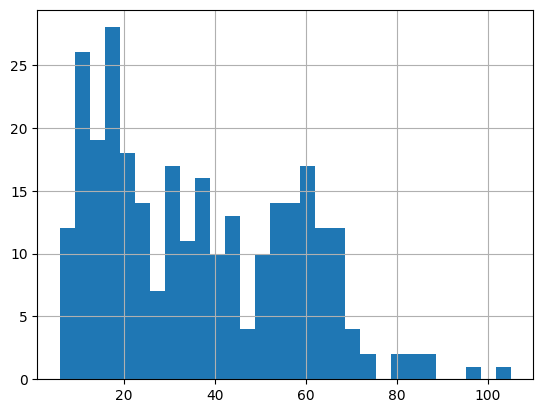

In [23]:
#text preprocessing
text_seq_length = 80
train_examples = dataToInputExample(train_data,text_seq_length)
val_examples = dataToInputExample(val_data,text_seq_length)
seq_len = [len(tokenizer.encode(i.text)) for i in train_examples[0]]
pd.Series(seq_len).hist(bins = 30)

In [24]:
#training parameters
epochs = 400
lr = 2e-04
tokenizer_length = 95 #sentence length
n_ways = 5 #clases
k_shots = 20 # vectores soporte
k_queries = 10 # querys

train_steps = 5

model = PrototypicalNetwork(bert)
model.to(device)
history = training(epochs, lr, tokenizer_length, n_ways, k_shots, k_queries, train_steps)


 Epoch 1 / 400


100%|██████████| 4/4 [00:05<00:00,  1.25s/it, accuracy=0.2500]



Training Loss: 1.608 Training Accuracy: 0.372
Validation Loss: 1.597 Validation Accuracy: 0.469

 Epoch 2 / 400


100%|██████████| 4/4 [00:04<00:00,  1.21s/it, accuracy=0.5000]



Training Loss: 1.559 Training Accuracy: 0.354
Validation Loss: 1.290 Validation Accuracy: 0.406

 Epoch 3 / 400


100%|██████████| 4/4 [00:04<00:00,  1.22s/it, accuracy=0.3750]



Training Loss: 1.386 Training Accuracy: 0.404
Validation Loss: 1.323 Validation Accuracy: 0.500

 Epoch 4 / 400


100%|██████████| 4/4 [00:05<00:00,  1.26s/it, accuracy=0.2500]



Training Loss: 1.201 Training Accuracy: 0.490
Validation Loss: 1.372 Validation Accuracy: 0.344

 Epoch 5 / 400


100%|██████████| 4/4 [00:05<00:00,  1.28s/it, accuracy=0.3750]



Training Loss: 1.042 Training Accuracy: 0.540
Validation Loss: 1.306 Validation Accuracy: 0.438

 Epoch 6 / 400


100%|██████████| 4/4 [00:05<00:00,  1.32s/it, accuracy=0.3750]



Training Loss: 0.791 Training Accuracy: 0.620
Validation Loss: 1.776 Validation Accuracy: 0.531

 Epoch 7 / 400


100%|██████████| 4/4 [00:05<00:00,  1.37s/it, accuracy=0.1250]



Training Loss: 0.671 Training Accuracy: 0.700
Validation Loss: 2.619 Validation Accuracy: 0.531

 Epoch 8 / 400


100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=0.3750]



Training Loss: 0.459 Training Accuracy: 0.856
Validation Loss: 3.228 Validation Accuracy: 0.562

 Epoch 9 / 400


100%|██████████| 4/4 [00:05<00:00,  1.37s/it, accuracy=0.6250]



Training Loss: 0.341 Training Accuracy: 0.882
Validation Loss: 3.492 Validation Accuracy: 0.531

 Epoch 10 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.248 Training Accuracy: 0.910
Validation Loss: 5.005 Validation Accuracy: 0.594

 Epoch 11 / 400


100%|██████████| 4/4 [00:05<00:00,  1.32s/it, accuracy=0.7500]



Training Loss: 0.166 Training Accuracy: 0.948
Validation Loss: 2.647 Validation Accuracy: 0.500

 Epoch 12 / 400


100%|██████████| 4/4 [00:05<00:00,  1.32s/it, accuracy=0.2500]



Training Loss: 0.105 Training Accuracy: 0.964
Validation Loss: 2.391 Validation Accuracy: 0.500

 Epoch 13 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=1.0000]



Training Loss: 0.075 Training Accuracy: 0.974
Validation Loss: 4.927 Validation Accuracy: 0.562

 Epoch 14 / 400


100%|██████████| 4/4 [00:05<00:00,  1.36s/it, accuracy=0.2500]



Training Loss: 0.084 Training Accuracy: 0.976
Validation Loss: 5.210 Validation Accuracy: 0.594

 Epoch 15 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.5000]



Training Loss: 0.050 Training Accuracy: 0.980
Validation Loss: 3.008 Validation Accuracy: 0.594

 Epoch 16 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.064 Training Accuracy: 0.988
Validation Loss: 2.687 Validation Accuracy: 0.625

 Epoch 17 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.021 Training Accuracy: 0.994
Validation Loss: 5.092 Validation Accuracy: 0.531

 Epoch 18 / 400


100%|██████████| 4/4 [00:05<00:00,  1.33s/it, accuracy=0.5000]



Training Loss: 0.022 Training Accuracy: 0.994
Validation Loss: 6.193 Validation Accuracy: 0.531

 Epoch 19 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.003 Training Accuracy: 1.000
Validation Loss: 6.650 Validation Accuracy: 0.562

 Epoch 20 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.012 Training Accuracy: 0.996
Validation Loss: 7.195 Validation Accuracy: 0.562

 Epoch 21 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.050 Training Accuracy: 0.990
Validation Loss: 7.498 Validation Accuracy: 0.625

 Epoch 22 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.011 Training Accuracy: 0.996
Validation Loss: 7.193 Validation Accuracy: 0.562

 Epoch 23 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.018 Training Accuracy: 0.994
Validation Loss: 6.414 Validation Accuracy: 0.594

 Epoch 24 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=1.0000]



Training Loss: 0.033 Training Accuracy: 0.994
Validation Loss: 2.700 Validation Accuracy: 0.719

 Epoch 25 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.037 Training Accuracy: 0.986
Validation Loss: 2.504 Validation Accuracy: 0.625

 Epoch 26 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.011 Training Accuracy: 0.994
Validation Loss: 3.668 Validation Accuracy: 0.625

 Epoch 27 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.8750]



Training Loss: 0.029 Training Accuracy: 0.990
Validation Loss: 4.301 Validation Accuracy: 0.594

 Epoch 28 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.024 Training Accuracy: 0.994
Validation Loss: 5.644 Validation Accuracy: 0.594

 Epoch 29 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.021 Training Accuracy: 0.994
Validation Loss: 6.425 Validation Accuracy: 0.531

 Epoch 30 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.008 Training Accuracy: 0.996
Validation Loss: 5.925 Validation Accuracy: 0.531

 Epoch 31 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.046 Training Accuracy: 0.990
Validation Loss: 5.183 Validation Accuracy: 0.562

 Epoch 32 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.005 Training Accuracy: 1.000
Validation Loss: 4.581 Validation Accuracy: 0.656

 Epoch 33 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.014 Training Accuracy: 0.992
Validation Loss: 3.815 Validation Accuracy: 0.688

 Epoch 34 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.007 Training Accuracy: 0.998
Validation Loss: 3.298 Validation Accuracy: 0.688

 Epoch 35 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.8750]



Training Loss: 0.006 Training Accuracy: 0.998
Validation Loss: 3.679 Validation Accuracy: 0.625

 Epoch 36 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.001 Training Accuracy: 1.000
Validation Loss: 4.031 Validation Accuracy: 0.594

 Epoch 37 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.8750]



Training Loss: 0.001 Training Accuracy: 1.000
Validation Loss: 3.982 Validation Accuracy: 0.594

 Epoch 38 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.002 Training Accuracy: 1.000
Validation Loss: 4.034 Validation Accuracy: 0.625

 Epoch 39 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 3.930 Validation Accuracy: 0.625

 Epoch 40 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 4.063 Validation Accuracy: 0.625

 Epoch 41 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 4.221 Validation Accuracy: 0.625

 Epoch 42 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 4.488 Validation Accuracy: 0.625

 Epoch 43 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 4.665 Validation Accuracy: 0.625

 Epoch 44 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.001 Training Accuracy: 1.000
Validation Loss: 4.573 Validation Accuracy: 0.625

 Epoch 45 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.1250]



Training Loss: 0.002 Training Accuracy: 0.998
Validation Loss: 5.297 Validation Accuracy: 0.562

 Epoch 46 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.450 Validation Accuracy: 0.562

 Epoch 47 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.5000]



Training Loss: 0.030 Training Accuracy: 0.996
Validation Loss: 4.653 Validation Accuracy: 0.625

 Epoch 48 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.003 Training Accuracy: 0.998
Validation Loss: 3.588 Validation Accuracy: 0.625

 Epoch 49 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.004 Training Accuracy: 1.000
Validation Loss: 3.832 Validation Accuracy: 0.594

 Epoch 50 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.003 Training Accuracy: 1.000
Validation Loss: 4.308 Validation Accuracy: 0.594

 Epoch 51 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.004 Training Accuracy: 0.998
Validation Loss: 4.667 Validation Accuracy: 0.625

 Epoch 52 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.004 Training Accuracy: 0.998
Validation Loss: 4.740 Validation Accuracy: 0.656

 Epoch 53 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.001 Training Accuracy: 1.000
Validation Loss: 5.302 Validation Accuracy: 0.625

 Epoch 54 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.003 Training Accuracy: 0.998
Validation Loss: 5.742 Validation Accuracy: 0.625

 Epoch 55 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.287 Validation Accuracy: 0.594

 Epoch 56 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.441 Validation Accuracy: 0.594

 Epoch 57 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.8750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.295 Validation Accuracy: 0.594

 Epoch 58 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.176 Validation Accuracy: 0.594

 Epoch 59 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.060 Validation Accuracy: 0.594

 Epoch 60 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.164 Validation Accuracy: 0.594

 Epoch 61 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.836 Validation Accuracy: 0.594

 Epoch 62 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.035 Validation Accuracy: 0.594

 Epoch 63 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.810 Validation Accuracy: 0.594

 Epoch 64 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.919 Validation Accuracy: 0.594

 Epoch 65 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.856 Validation Accuracy: 0.594

 Epoch 66 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.834 Validation Accuracy: 0.594

 Epoch 67 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.885 Validation Accuracy: 0.594

 Epoch 68 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.8750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.861 Validation Accuracy: 0.594

 Epoch 69 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 6.009 Validation Accuracy: 0.594

 Epoch 70 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.803 Validation Accuracy: 0.594

 Epoch 71 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.905 Validation Accuracy: 0.594

 Epoch 72 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.877 Validation Accuracy: 0.594

 Epoch 73 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.899 Validation Accuracy: 0.594

 Epoch 74 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.696 Validation Accuracy: 0.594

 Epoch 75 / 400


100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.834 Validation Accuracy: 0.594

 Epoch 76 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.720 Validation Accuracy: 0.594

 Epoch 77 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.853 Validation Accuracy: 0.594

 Epoch 78 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.856 Validation Accuracy: 0.594

 Epoch 79 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.760 Validation Accuracy: 0.594

 Epoch 80 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.899 Validation Accuracy: 0.594

 Epoch 81 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.803 Validation Accuracy: 0.594

 Epoch 82 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.602 Validation Accuracy: 0.594

 Epoch 83 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.720 Validation Accuracy: 0.594

 Epoch 84 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.685 Validation Accuracy: 0.594

 Epoch 85 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.940 Validation Accuracy: 0.594

 Epoch 86 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.731 Validation Accuracy: 0.594

 Epoch 87 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.891 Validation Accuracy: 0.594

 Epoch 88 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.786 Validation Accuracy: 0.594

 Epoch 89 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.5000]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.814 Validation Accuracy: 0.594

 Epoch 90 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.2500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.747 Validation Accuracy: 0.594

 Epoch 91 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.787 Validation Accuracy: 0.594

 Epoch 92 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.7500]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.768 Validation Accuracy: 0.594

 Epoch 93 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.6250]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.950 Validation Accuracy: 0.594

 Epoch 94 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.742 Validation Accuracy: 0.594

 Epoch 95 / 400


100%|██████████| 4/4 [00:05<00:00,  1.34s/it, accuracy=0.3750]



Training Loss: 0.000 Training Accuracy: 1.000
Validation Loss: 5.810 Validation Accuracy: 0.594

 Epoch 96 / 400


 20%|██        | 1/5 [00:02<00:10,  2.73s/it, accuracy=1.0000]


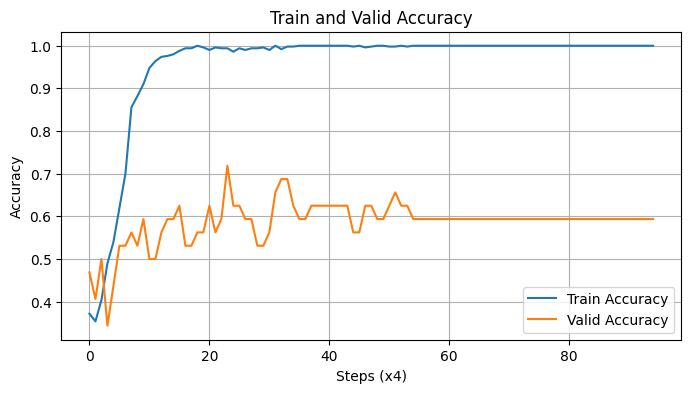

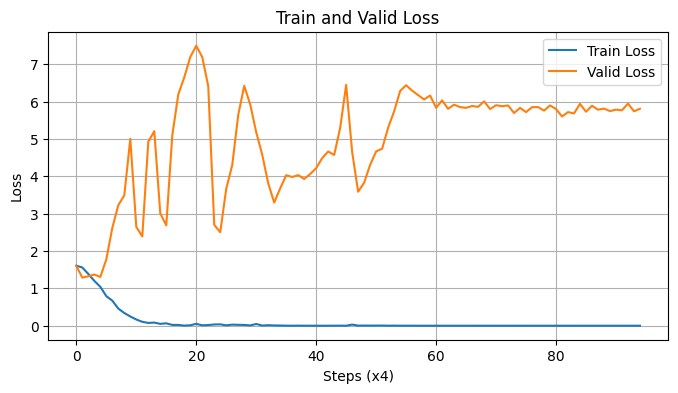

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(train_accuracies, train_losses, valid_accuracies, valid_losses):
    # plot train and valid accuracy on the same plot
    plt.figure(figsize=(8,4))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Steps (x4)')
    plt.ylabel('Accuracy')
    plt.title('Train and Valid Accuracy')
    plt.grid()
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()

    # plot train and valid loss on the same plot
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Steps (x4)')
    plt.ylabel('Loss')
    plt.title('Train and Valid Loss')
    plt.grid()
    plt.legend()
    plt.savefig('loss.png')
    plt.show()

plot_metrics(*history)

In [26]:
def save_prototypes(input_examples, model, tokenizer, output_name, tokenizer_length=100):
  proto_examples, proto_labels = input_examples
  proto_dict = {label:[] for label in list(set(proto_labels))}
  with torch.no_grad():
    for data in proto_examples:
      feature = tokenizer.encode_plus(
                data.text,
                max_length = tokenizer_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                add_special_tokens = True,
                return_tensors = 'pt',
                )
      input_ids = feature['input_ids'].to(device)
      input_ids_shape = input_ids.size()
      attention_mask = feature['attention_mask'].to(device)
      input_ids = input_ids.view(1,1,*input_ids_shape)  
      attention_mask = attention_mask.view(1,1,*input_ids_shape)
      input_embeding = model(input_ids, attention_mask)
      proto_dict[data.label].append(input_embeding)
  for key, value in proto_dict.items():
    proto_dict[key] = torch.mean(torch.cat(value, dim=1),1)
  torch.save({
      'model_state_dic': model.state_dict(),
      'prototypes': proto_dict
    }, output_name)

# bert = AutoModel.from_pretrained('yiyanghkust/finbert-tone')
# tokenizer = BertTokenizerFast.from_pretrained('yiyanghkust/finbert-tone',do_lower_case=True)
output_file_name = "weights.pth"
model = PrototypicalNetwork(bert)
state_dict = torch.load('saved_weights.pt')
model.load_state_dict(state_dict)
model.to(device)
save_prototypes(train_examples, model, tokenizer, output_file_name, tokenizer_length)

In [ ]:
def evaluating(tokenizer_length,n_ways, k_shots):
  # Example usage:
  crypto_data = CryptocurrencyDatasetEval(train_examples,val_examples, tokenizer, tokenizer_length, n_ways, k_shots)
  data_loader = DataLoader(crypto_data, batch_size=5, shuffle=False)
  
  valid_loss, valid_accuracy, labels, predicted_labels = test(model, data_loader)
  labels = [crypto_data.id_to_proto_classes[i] for i in labels]
  predicted_labels = [crypto_data.id_to_proto_classes[i] for i in predicted_labels]
  print(classification_report(labels, predicted_labels))
  print(valid_loss, valid_accuracy)


In [ ]:
model = PrototypicalNetwork(bert)
state_dict = torch.load('saved_weights.pt')
model.load_state_dict(state_dict)
model.to(device)
evaluating(tokenizer_length, n_ways, k_shots=10)

100%|██████████| 6/6 [00:05<00:00,  1.09it/s, accuracy=0.0000]

                       precision    recall  f1-score   support

          advertising       1.00      0.50      0.67         8
         announcement       0.43      1.00      0.60         3
financial information       0.86      0.67      0.75         9
   subjective opinion       0.50      0.67      0.57         6

             accuracy                           0.65        26
            macro avg       0.70      0.71      0.65        26
         weighted avg       0.77      0.65      0.67        26

10.179399490356445 0.5666666825612386


In [ ]:
model = PrototypicalNetwork(bert)
state_dict = torch.load('saved_weights_a.pt')
model.load_state_dict(state_dict)
model.to(device)
evaluating(tokenizer_length, n_ways, k_shots=10)

100%|██████████| 6/6 [00:01<00:00,  3.84it/s, accuracy=1.0000]

                       precision    recall  f1-score   support

          advertising       1.00      0.25      0.40         8
         announcement       0.33      1.00      0.50         3
financial information       1.00      0.67      0.80         9
   subjective opinion       0.44      0.67      0.53         6

             accuracy                           0.58        26
            macro avg       0.69      0.65      0.56        26
         weighted avg       0.79      0.58      0.58        26

2.9677700890849033 0.6333333452542623


# PAM

In [27]:
# import torch.nn.functional as F

def get_accuracyy(prototypes, embeddings):
    """Compute the accuracy of the prototypical network on the test/query points.
    Parameters
    ----------
    prototypes : `torch.FloatTensor` instance
        A tensor containing the prototypes for each class. This tensor has shape 
        `(meta_batch_size, num_classes, embedding_size)`.
    embeddings : `torch.FloatTensor` instance
        A tensor containing the embeddings of the query points. This tensor has 
        shape `(meta_batch_size, num_examples, embedding_size)`.
    Returns
    -------
    probability : `torch.FloatTensor` instance
    index of probability:    torch.Int
    """
    # Calcula la distancia euclidiana entre cada prototipo y las incrustaciones de las muestras de consulta
    distances = torch.sum((prototypes.unsqueeze(1)
        - embeddings.unsqueeze(2)) ** 2, dim=-1)
    
    # Calcula la probabilidad mediante la aplicación de Softmax sobre la negación de las distancias
    neg_distances = -distances
    probability = F.softmax(neg_distances, dim=-1)
    
    # Encuentra la clase predicha para cada muestra de consulta
    y_hat, index = torch.max(probability, dim=-1)

    return y_hat, index


In [28]:
class InputExample(object):
  def __init__(self, twitter_id, text, label='unk'):
    self.twitter_id = twitter_id
    self.text = text
    self.label = label
      
def read_examples(input_file, max_length=100):
  examples = []
  labels = []
  with open(input_file, 'r') as f:
    for line in f:
      obj = json.loads(line)
      text = [text['text'] for text in obj['texts']]
      text = ' '.join(text)
      text = preprocess_text(text)
      text_split = text.split()
      text_length = len(text_split)
      new_text = []
      for i in range(math.ceil(text_length/max_length)):
        if (i+1)*max_length>= text_length:
          new_text.append(' '.join(text_split[-max_length:]))
        else:
          new_text.append(' '.join(text_split[i*max_length:(i+1)*max_length]))
      label = 'unk'
      if 'class' in obj:
        label = obj['class']
      labels.append(label)
      if len(new_text)==0:
        new_text.append("")
      examples.append(InputExample(twitter_id=obj['twitter user id'], text=new_text, label=label))
  return examples, labels

def load_prototypes(proto_dict):
  # proto_dict = torch.load(file_name)
  proto_stack = torch.stack(list(proto_dict.values()), dim=1)
  labels = list(proto_dict.keys())
  return proto_stack, labels

In [29]:
# tokenizer_length = 100
#Load tokenizer
# bert = AutoModel.from_pretrained('yiyanghkust/finbert-tone')
# tokenizer = BertTokenizerFast.from_pretrained('yiyanghkust/finbert-tone',do_lower_case=True)
# Initialize Model
model = PrototypicalNetwork(bert)
# state_dict = torch.jit.load('./task1/saved_weights.pt')
# state_dict = torch.load('./saved_weights.pt', map_location=torch.device('cpu'))
checkpoint = torch.load('./weights.pth')
model.load_state_dict(checkpoint['model_state_dic'])

model.to(device)
model.eval()

# Read example files
examples, _ = read_examples('./val.json')
y_hats = []
y = []
results = []
with torch.no_grad():
  prototypes, labels = load_prototypes(checkpoint['prototypes'])
  for i, example in enumerate(examples):
    encode = tokenizer.batch_encode_plus(
                example.text,
                max_length = tokenizer_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                add_special_tokens = True,
                return_tensors = 'pt',
                )
    input_ids = encode['input_ids'].to(device)
    input_ids_shape = input_ids.size()
    attention_mask = encode['attention_mask'].to(device)
    input_ids = input_ids.view(1,1,*input_ids_shape)  
    attention_mask = attention_mask.view(1,1,*input_ids_shape)
    input_embeding = model(input_ids, attention_mask)
    input_embeding = torch.mean(input_embeding, 1, keepdim=True)  
    y_hat, y_hat_id = get_accuracyy(prototypes, input_embeding)
    # print(y_hat.item(), labels[y_hat_id.item()])
    y_hats.append(labels[y_hat_id.item()])
    y.append(example.label)
    results.append({"twitter user id":example.twitter_id, "class":labels[y_hat_id.item()], "probability":round(y_hat.item(),3)})

with open('subtask1.json', 'w', encoding='utf-8') as f:
  for obj in results:
    f.write(json.dumps(obj))
    f.write('\n')
  f.close()
print(classification_report(y, y_hats))

                       precision    recall  f1-score   support

               gaming       0.89      0.89      0.89         9
                other       0.75      0.60      0.67         5
         price update       0.75      0.38      0.50         8
technical information       0.80      0.80      0.80         5
      trading matters       0.50      1.00      0.67         5

             accuracy                           0.72        32
            macro avg       0.74      0.73      0.70        32
         weighted avg       0.76      0.72      0.71        32



                       precision    recall  f1-score   support

               gaming       0.89      0.89      0.89         9
                other       0.43      0.60      0.50         5
         price update       1.00      0.38      0.55         8
technical information       0.57      0.80      0.67         5
      trading matters       0.67      0.80      0.73         5

             accuracy                           0.69        32
            macro avg       0.71      0.69      0.67        32
         weighted avg       0.76      0.69      0.68        32

